In [13]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import random as rand
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datasets import load_dataset, Dataset
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from mediapipe_handler import MediaPipeHandler
# from get_work_out_labels import add_workout_label_back, add_muscle_groups_label

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import Dataset, DataLoader

max_pose_noise = 0.1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mediapipe_handler = MediaPipeHandler()
current_dir = os.getcwd()

I0000 00:00:1750808881.861061 8893072 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4 Pro
W0000 00:00:1750808881.923716 8913806 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1750808881.934131 8913814 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [14]:
class PoseAdjustmentDataset(Dataset):
    def __init__(self, X_df, y_df, label_column='label'):
        """Now correctly includes workout as a feature"""
        # Process ALL input features including the label
        self.features = X_df.values.astype('float32')  # Contains both pose (66) + workout (1) = 67
        
        # Verify we have 67 features (66 pose + 1 workout)
        assert self.features.shape[1] == 37, f"Expected 67 features (66 pose + 1 workout), got {self.features.shape[1]}"
        
        # Process targets
        self.targets = y_df.values.astype('float32')

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return {
            'features': torch.tensor(self.features[idx], dtype=torch.float32),  # All 67 features
            'target': torch.tensor(self.targets[idx], dtype=torch.float32)
        }

class EnhancedPoseModel(nn.Module):
    def __init__(self, input_dim=37, hidden_dim=512, output_dim=36):
        super().__init__()
        
        # Main network architecture
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh()
        )
        
        # Initialize weights properly
        self._initialize_weights()
        
    def _initialize_weights(self):
        """Initialize weights with Kaiming normal and zero biases"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                    
    def forward(self, x):
        return self.net(x) * max_pose_noise  # Scale tanh output to [-0.1, 0.1] range

In [ ]:
def plot_comparison(true, pred, title="Predictions vs True Values"):
    """Enhanced visualization with heatmap-style connecting lines"""
    plt.figure(figsize=(14, 6))
    
    # Calculate errors and normalize for coloring
    errors = np.abs(true - pred)
    max_error = np.max(errors) if np.max(errors) > 0 else 1  # Avoid division by zero
    normalized_errors = errors / max_error
    
    # Create a colormap (red for large errors, green for small)
    cmap = plt.get_cmap('RdYlGn_r')  # Reversed so red=bad, green=good
    colors = cmap(normalized_errors)
    
    # Create indices for plotting
    indices = np.arange(len(true))
    
    # Main scatter plot
    plt.subplot(1, 2, 1)
    sc_true = plt.scatter(indices, true, label='True', alpha=0.8, s=25, color='blue', zorder=3)
    sc_pred = plt.scatter(indices, pred, label='Predicted', alpha=0.8, s=25, marker='x', color='red', zorder=3)
    
    # Add connecting lines with heat colors
    for i in indices:
        plt.plot([i, i], [true[i], pred[i]], 
                color=colors[i], 
                alpha=0.6, 
                linewidth=2 + 2*normalized_errors[i],  # Thicker lines for larger errors
                zorder=1)
    
    # Add colorbar for error magnitude
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max_error))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.01)
    cbar.set_label('Absolute Error', rotation=270, labelpad=15)
    
    plt.xlabel("Feature Index")
    plt.ylabel("Value")
    plt.title("Value Comparison with Error Heatlines")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Error distribution plot
    plt.subplot(1, 2, 2)
    hist = plt.hist(errors, bins=30, color='green', alpha=0.7, density=True)
    
    # Add KDE plot
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(errors)
    x_vals = np.linspace(0, max_error, 100)
    plt.plot(x_vals, kde(x_vals), color='darkgreen', linewidth=2)
    
    plt.xlabel("Prediction Error (Absolute)")
    plt.ylabel("Density")
    plt.title(f"Error Distribution\nMAE: {np.mean(errors):.4f} | Max Error: {max_error:.4f}")
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(title, y=1.02)
    plt.tight_layout()
    
    # Add overall statistics as text
    stats_text = (f"Mean Error: {np.mean(errors):.4f}\n"
                 f"Median Error: {np.median(errors):.4f}\n"
                 f"Std Dev: {np.std(errors):.4f}\n"
                 f"R² Score: {1 - np.sum(errors**2)/np.sum((true - np.mean(true))**2):.4f}")
    
    plt.gcf().text(0.95, 0.5, stats_text, 
                  bbox=dict(facecolor='white', alpha=0.5), 
                  verticalalignment='center')
    
    plt.show()

def calculate_r2_score(pred, target):
    """Calculate R² score for a batch"""
    # R² = 1 - SS_res / SS_tot
    ss_res = torch.sum((target - pred) ** 2)
    ss_tot = torch.sum((target - torch.mean(target)) ** 2)
    r2 = 1 - ss_res / (ss_tot + 1e-8)  # Small epsilon to avoid division by zero
    return r2.item()

def train_model(model, train_loader, val_loader, device, epochs=50):
    """Enhanced training loop with MAE, MSE, R² scores and visualization"""
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
    
    best_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_r2 = 0
        train_mae = 0
        train_mse = 0
        
        for batch in train_loader:
            optimizer.zero_grad()
            outputs = model(batch['features'].to(device))
            targets = batch['target'].to(device)
            
            loss = F.mse_loss(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            # Calculate metrics
            train_loss += loss.item()
            train_r2 += calculate_r2_score(outputs, targets)
            train_mae += F.l1_loss(outputs, targets).item()
            train_mse += loss.item()  # Already MSE
        
        # Validation
        model.eval()
        val_loss = 0
        val_r2 = 0
        val_mae = 0
        val_mse = 0
        sample_outputs = []
        sample_targets = []
        
        with torch.no_grad():
            for batch in val_loader:
                outputs = model(batch['features'].to(device))
                targets = batch['target'].to(device)
                
                val_loss += F.mse_loss(outputs, targets).item()
                val_r2 += calculate_r2_score(outputs, targets)
                val_mae += F.l1_loss(outputs, targets).item()
                val_mse += F.mse_loss(outputs, targets).item()
                
                # Store samples for visualization
                if len(sample_outputs) < 3:
                    sample_outputs.append(outputs[0].cpu().numpy())
                    sample_targets.append(targets[0].cpu().numpy())
        
        # Calculate average metrics
        train_loss /= len(train_loader)
        train_r2 /= len(train_loader)
        train_mae /= len(train_loader)
        train_mse /= len(train_loader)
        
        val_loss /= len(val_loader)
        val_r2 /= len(val_loader)
        val_mae /= len(val_loader)
        val_mse /= len(val_loader)
        
        scheduler.step(val_loss)
        
        # Enhanced epoch output with all metrics
        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"Train Metrics:")
        print(f"  Loss: {train_loss:.6f} | MAE: {train_mae:.6f} | MSE: {train_mse:.6f} | R²: {train_r2:.4f}")
        print(f"Val Metrics:")
        print(f"  Loss: {val_loss:.6f} | MAE: {val_mae:.6f} | MSE: {val_mse:.6f} | R²: {val_r2:.4f}")
        print(f"Current LR: {optimizer.param_groups[0]['lr']:.2e}")
        
        # Visualize samples periodically with metrics in title
        if (epoch+1) % 300 == 0 or epoch == epochs-1:
            for i, (true, pred) in enumerate(zip(sample_targets, sample_outputs)):
                plot_title = (f"Epoch {epoch+1} - Sample {i+1}\n"
                             f"Train MAE: {train_mae:.4f} | Val MAE: {val_mae:.4f}\n"
                             f"Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f}")
                plot_comparison(true, pred, plot_title)
        
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), current_dir + '/../models/pose_correctors/dnn_pose_adjustor.pth')
            print("↳ Saved new best model")
    
    return model

def preprocess_data(dataframe, columns_to_flatten):
    """More efficient preprocessing"""
    # Create expanded columns first
    expanded_cols = {}
    for col in columns_to_flatten:
        arr = np.vstack(dataframe[col].values)
        expanded_cols.update({
            f"{col}_x": arr[:, 0],
            f"{col}_y": arr[:, 1],
            f"{col}_z": arr[:, 2]
        })
    
    # Combine all at once
    expanded_df = pd.DataFrame(expanded_cols, index=dataframe.index)
    return pd.concat([dataframe.drop(columns=columns_to_flatten), expanded_df], axis=1)

"""
Splits dataset into X_train,y_train or X_test,y_test, if you give it training dataset then X_train and y_train

"""
def Return_X_y(dataframe,X_columns_to_delete, Y_columns_to_delete):
    X=dataframe.drop(columns=X_columns_to_delete)
    y=dataframe.drop(columns=Y_columns_to_delete)
    return X,y

In [16]:
def display_class_distribution(classes):    
    plt.figure(figsize=(20,8))
    value_counts = classes.value_counts()
    percentages = value_counts / value_counts.sum() * 100

    # Plot
    ax = percentages.plot(kind='bar', color='skyblue')

    # Add percentage text on each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

    plt.title('Training Dataset muscle group Distribution (Percentage)')
    plt.ylabel('Percentage')
    plt.show()

In [17]:
features_to_split=['left_shoulder', 'left_shoulder_displacement',
       'right_shoulder', 'right_shoulder_displacement', 'left_elbow', 'left_elbow_displacement', 'right_elbow', 'right_elbow_displacement', 'left_wrist', 'left_wrist_displacement',
       'right_wrist', 'right_wrist_displacement', 'left_hip', 'left_hip_displacement', 'right_hip', 'right_hip_displacement', 'left_knee', 'left_knee_displacement',
       'right_knee', 'right_knee_displacement', 'left_ankle', 'left_ankle_displacement', 'right_ankle', 'right_ankle_displacement'] 

# training_dataset_preprocessed=Preprocess_data(training_dataset,features_to_split)
# X_train, y_train = Return_X_y(training_dataset_preprocessed,['label','muscle group','image','Unnamed: 0'])

base_columns = ['muscle group','image','Unnamed: 0']

pose_columns = ['left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z',
       'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'left_wrist_x', 'left_wrist_y', 'left_wrist_z',
       'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'left_knee_x', 'left_knee_y', 'left_knee_z',
       'right_knee_x', 'right_knee_y', 'right_knee_z', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z']

displacement_columns = ['left_shoulder_displacement_x', 'left_shoulder_displacement_y', 'left_shoulder_displacement_z',
       'right_shoulder_displacement_x', 'right_shoulder_displacement_y', 'right_shoulder_displacement_z', 'left_elbow_displacement_x', 'left_elbow_displacement_y', 'left_elbow_displacement_z', 'right_elbow_displacement_x', 'right_elbow_displacement_y', 'right_elbow_displacement_z', 'left_wrist_displacement_x', 'left_wrist_displacement_y', 'left_wrist_displacement_z',
       'right_wrist_displacement_x', 'right_wrist_displacement_y', 'right_wrist_displacement_z', 'left_hip_displacement_x', 'left_hip_displacement_y', 'left_hip_displacement_z', 'right_hip_displacement_x', 'right_hip_displacement_y', 'right_hip_displacement_z', 'left_knee_displacement_x', 'left_knee_displacement_y', 'left_knee_displacement_z',
       'right_knee_displacement_x', 'right_knee_displacement_y', 'right_knee_displacement_z', 'left_ankle_displacement_x', 'left_ankle_displacement_y', 'left_ankle_displacement_z', 'right_ankle_displacement_x', 'right_ankle_displacement_y', 'right_ankle_displacement_z']

X_columns_to_delete = base_columns + displacement_columns
y_columns_to_delete = base_columns + pose_columns + ['label']

def joint_accuracy(pred, true, threshold=0.01):
    return (torch.abs(pred - true) < threshold).float().mean()

In [18]:
training_dataset=mediapipe_handler.read_csv_to_pd_displacement(current_dir + "/../data/train_with_displacement.csv")
testing_dataset=mediapipe_handler.read_csv_to_pd_displacement(current_dir + "/../data/train_with_displacement.csv")
validation_dataset=mediapipe_handler.read_csv_to_pd_displacement(current_dir + "/../data/validation_with_displacement.csv")

KeyboardInterrupt: 

In [ ]:
training_dataset_preprocessed = preprocess_data(training_dataset, features_to_split)
X_train_pre, y_train_pre = Return_X_y(training_dataset_preprocessed, X_columns_to_delete, y_columns_to_delete)

testing_dataset_preprocessed = preprocess_data(testing_dataset, features_to_split)
X_test, y_test = Return_X_y(testing_dataset_preprocessed, X_columns_to_delete, y_columns_to_delete)

print(f"Training data shape: {X_train_pre.shape}")
expected_dim = len(pose_columns) + 1
if X_train_pre.shape[1] != expected_dim:
    print(f"Warning: Expected {expected_dim} features, got {X_train_pre.shape[1]}")

Training data shape: (148427, 37)


,left_shoulder_displacement_x,left_shoulder_displacement_y,left_shoulder_displacement_z,right_shoulder_displacement_x,right_shoulder_displacement_y,right_shoulder_displacement_z,left_elbow_displacement_x,left_elbow_displacement_y,left_elbow_displacement_z,right_elbow_displacement_x,...,left_knee_displacement_z,right_knee_displacement_x,right_knee_displacement_y,right_knee_displacement_z,left_ankle_displacement_x,left_ankle_displacement_y,left_ankle_displacement_z,right_ankle_displacement_x,right_ankle_displacement_y,right_ankle_displacement_z
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.053072,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.087184,-0.051913,0.085838,0.000000,0.000000,0.000000,0.000000,...,-0.063776,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-0.079643,0.000038,0.054256,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-0.009112,0.016441,0.019779,0.000000,0.000000,0.000000,-0.018368,-0.005131,-0.003469,0.009389,...,0.002907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148422,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014601,...,0.002215,-0.002174,0.016269,0.010632,0.000000,0.000000,0.000000,0.009085,-0.000974,-0.011097
148423,0.075432,0.087423,-0.095078,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
148424,0.000000,0.000000,0.000000,-0.019321,0.018478,0.004389,0.000000,0.000000,0.000000,0.000000,...,0.002717,0.000000,0.000000,0.000000,-0.010260,-0.006878,-0.008785,0.007602,0.003011,-0.013351
148425,0.000000,0.000000,0.000000,0.010386,0.007934,0.005578,-0.008941,-0.019773,0.018807,0.000000,...,0.005679,-0.018630,-0.016851,0.017558,-0.011018,-0.015171,-0.004671,0.000000,0.000000,0.000000


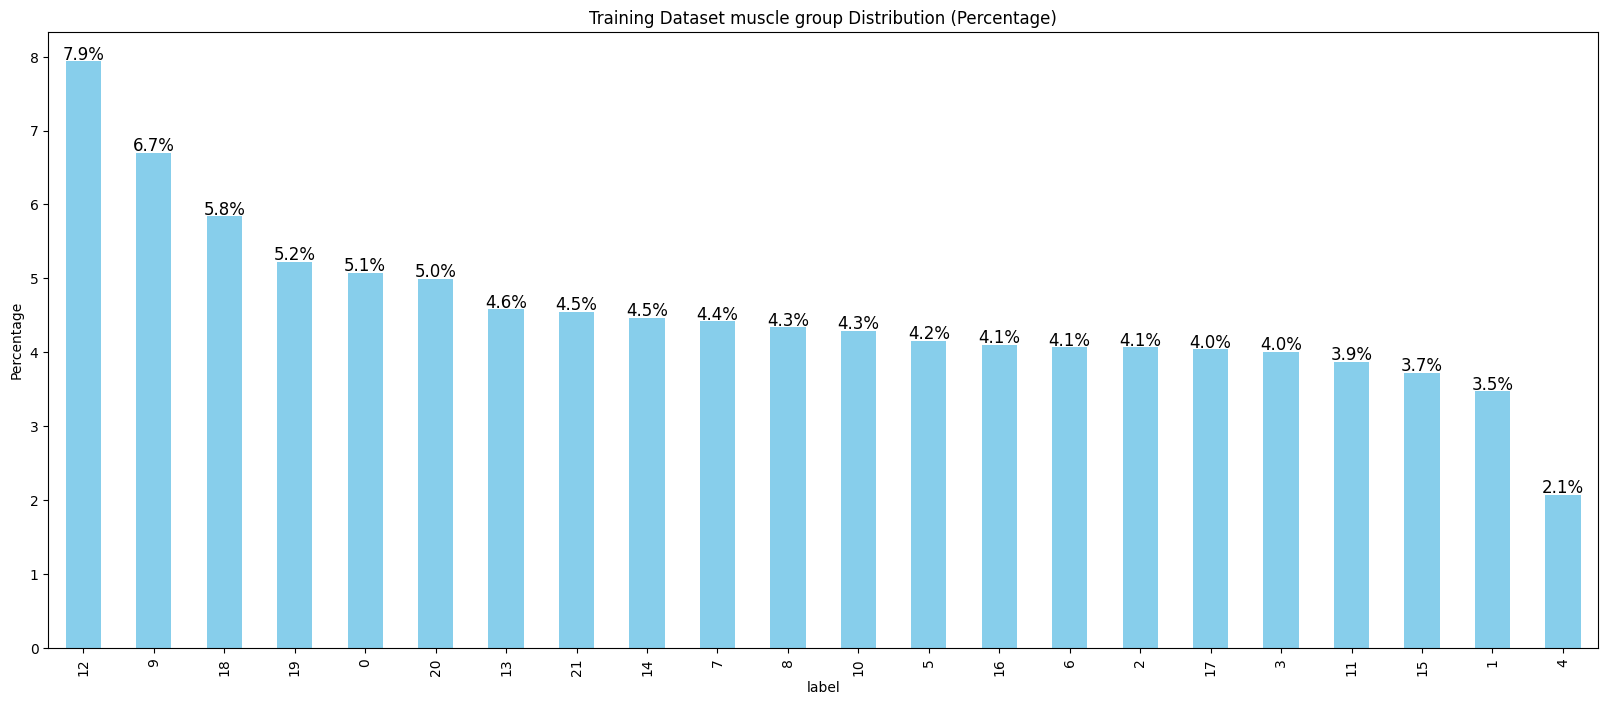

In [ ]:
display_class_distribution(X_train_pre['label'])

In [ ]:
def balance_by_category(X_train: pd.DataFrame, y_train: np.ndarray, category_column: str = 'label', random_state: int = 42):
    """
    Oversample underrepresented categories in X_train[category_column],
    and duplicate corresponding y_train rows accordingly.

    Parameters:
    - X_train (pd.DataFrame): 30 float columns + 1 categorical 'label'
    - y_train (np.ndarray): shape (n_samples, 30), continuous target
    - category_column (str): column in X_train to balance on
    - random_state (int): for reproducibility

    Returns:
    - X_balanced (pd.DataFrame)
    - y_balanced (np.ndarray)
    """
    # Convert y_train to DataFrame for combining
    y_df = pd.DataFrame(y_train)
    
    # Combine X and y into one DataFrame
    full_data = pd.concat([X_train.reset_index(drop=True), y_df.reset_index(drop=True)], axis=1)

    # Find max size of any category
    max_size = full_data[category_column].value_counts().max()

    balanced_chunks = []
    for cat_value in full_data[category_column].unique():
        group = full_data[full_data[category_column] == cat_value]
        upsampled = resample(
            group,
            replace=True,
            n_samples=max_size,
            random_state=random_state
        )
        balanced_chunks.append(upsampled)

    # Combine all upsampled groups
    balanced_full = pd.concat(balanced_chunks).reset_index(drop=True)

    # Separate back into X and y
    X_balanced = balanced_full[X_train.columns]
    y_balanced = balanced_full[y_df.columns].to_numpy()

    return X_balanced, y_balanced

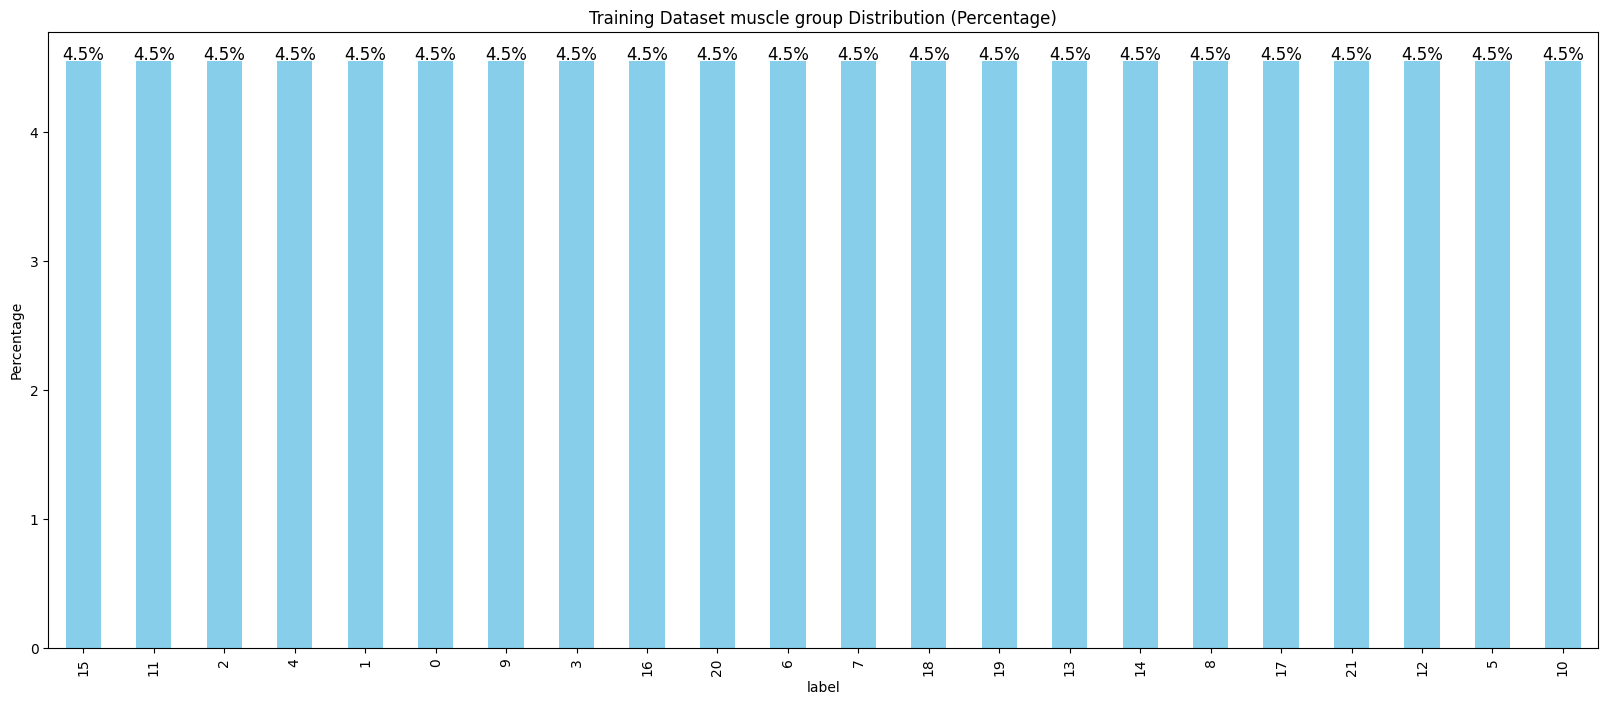

259182
259182


,left_shoulder_displacement_x,left_shoulder_displacement_y,left_shoulder_displacement_z,right_shoulder_displacement_x,right_shoulder_displacement_y,right_shoulder_displacement_z,left_elbow_displacement_x,left_elbow_displacement_y,left_elbow_displacement_z,right_elbow_displacement_x,...,left_knee_displacement_z,right_knee_displacement_x,right_knee_displacement_y,right_knee_displacement_z,left_ankle_displacement_x,left_ankle_displacement_y,left_ankle_displacement_z,right_ankle_displacement_x,right_ankle_displacement_y,right_ankle_displacement_z
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.053072,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.087184,-0.051913,0.085838,0.000000,0.000000,0.000000,0.000000,...,-0.063776,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-0.079643,0.000038,0.054256,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-0.009112,0.016441,0.019779,0.000000,0.000000,0.000000,-0.018368,-0.005131,-0.003469,0.009389,...,0.002907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148422,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014601,...,0.002215,-0.002174,0.016269,0.010632,0.000000,0.000000,0.000000,0.009085,-0.000974,-0.011097
148423,0.075432,0.087423,-0.095078,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
148424,0.000000,0.000000,0.000000,-0.019321,0.018478,0.004389,0.000000,0.000000,0.000000,0.000000,...,0.002717,0.000000,0.000000,0.000000,-0.010260,-0.006878,-0.008785,0.007602,0.003011,-0.013351
148425,0.000000,0.000000,0.000000,0.010386,0.007934,0.005578,-0.008941,-0.019773,0.018807,0.000000,...,0.005679,-0.018630,-0.016851,0.017558,-0.011018,-0.015171,-0.004671,0.000000,0.000000,0.000000


In [ ]:
X_train, y_train = balance_by_category(X_train_pre, y_train_pre)
display_class_distribution(X_train['label'])
print(len(X_train))
print(len(y_train))

X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create datasets
train_dataset = PoseAdjustmentDataset(X_train, y_train)
val_dataset = PoseAdjustmentDataset(X_test, y_test)

# Verify dataset dimensions
print(f"Train dataset pose features: {train_dataset.features.shape}")
print(f"Val dataset pose features: {val_dataset.features.shape}")

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Train dataset pose features: (207345, 37)
Val dataset pose features: (51837, 37)


In [ ]:
model = EnhancedPoseModel()
    
    # Train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = train_model(model, train_loader, val_loader, device, epochs=300)


Epoch 1/300
Train Metrics:
  Loss: 0.003128 | MAE: 0.035795 | MSE: 0.003128 | R²: -13.9310
Val Metrics:
  Loss: 0.002449 | MAE: 0.028760 | MSE: 0.002449 | R²: -10.6947
Current LR: 5.00e-04
↳ Saved new best model

Epoch 2/300
Train Metrics:
  Loss: 0.001982 | MAE: 0.024646 | MSE: 0.001982 | R²: -8.4640
Val Metrics:
  Loss: 0.001878 | MAE: 0.023671 | MSE: 0.001878 | R²: -7.9621
Current LR: 5.00e-04
↳ Saved new best model

Epoch 3/300
Train Metrics:
  Loss: 0.001619 | MAE: 0.021206 | MSE: 0.001619 | R²: -6.7204
Val Metrics:
  Loss: 0.001589 | MAE: 0.020905 | MSE: 0.001589 | R²: -6.5772
Current LR: 5.00e-04
↳ Saved new best model

Epoch 4/300
Train Metrics:
  Loss: 0.001337 | MAE: 0.018541 | MSE: 0.001337 | R²: -5.3684
Val Metrics:
  Loss: 0.001301 | MAE: 0.018088 | MSE: 0.001301 | R²: -5.1982
Current LR: 5.00e-04
↳ Saved new best model

Epoch 5/300
Train Metrics:
  Loss: 0.001302 | MAE: 0.018151 | MSE: 0.001302 | R²: -5.1968
Val Metrics:
  Loss: 0.001298 | MAE: 0.018008 | MSE: 0.001298 |

KeyboardInterrupt: 

R² Score: 0.5381
MSE: 0.00006107
MAE: 0.00441208
MAPE: 8560929406976.00000000


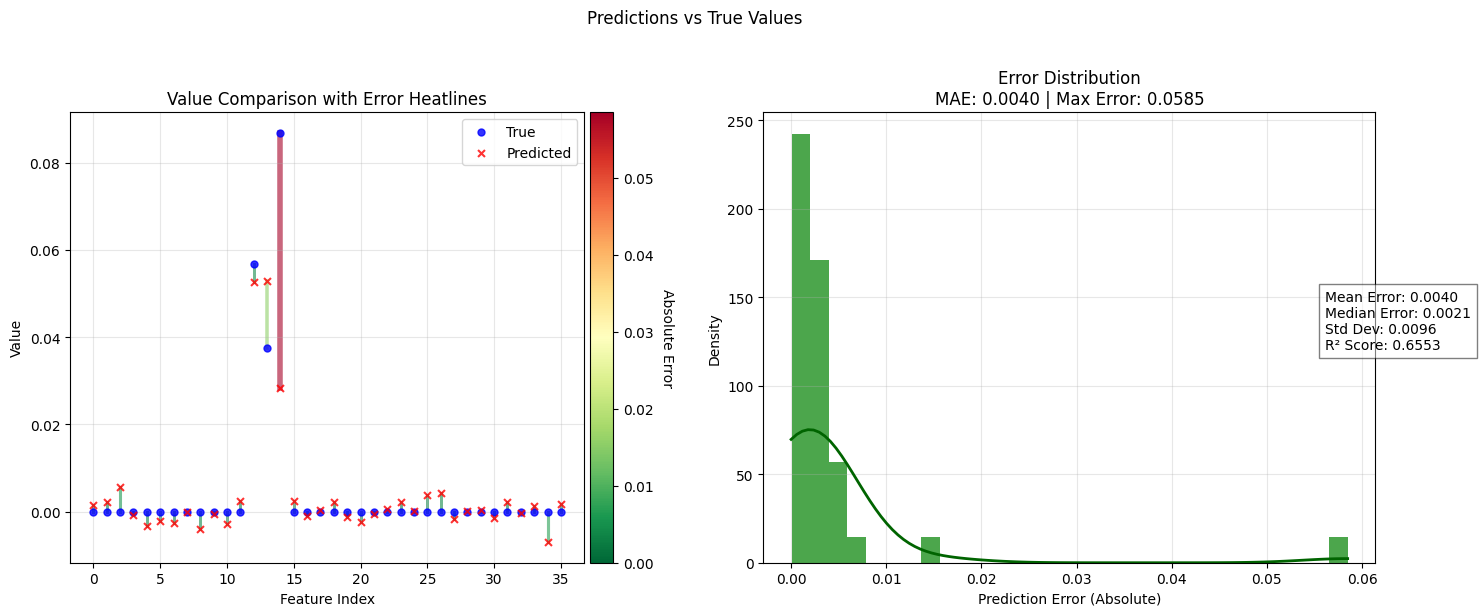

In [ ]:
input_tensor = torch.tensor(X_test.values, dtype=torch.float32)

model.eval()

with torch.no_grad():
    y_pred = model(input_tensor)
y_pred = y_pred.numpy()

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.8f}")
print(f"MAE: {mae:.8f}")
print(f"MAPE: {mape:.8f}")

index = rand.randint(0, len(y_pred - 1))
y_test_np = y_test
y_test_np = y_test.to_numpy()

plot_comparison(y_test_np[index], y_pred[index])


In [ ]:
import cv2
from PIL import Image

image_path = current_dir + "/../data/image.png" #Change to whatever image you want

image = Image.open(image_path)
vis = image.copy()
vis = image.convert("RGB")

# Convert PIL image to numpy array
vis = np.array(vis)

image_formated = mediapipe_handler.format_image_from_PIL(image)
detection = mediapipe_handler.predict_from_image(image_formated)
pose_detection = mediapipe_handler.predict_pose_from_image(image_formated).flatten()
# print(pose_detection)

noise_filter = 0
for i in range(len(pose_detection)):
    pose_detection[i] = rand.uniform(pose_detection[i] - noise_filter, pose_detection[i] + noise_filter) 
    # if pose_detection[i] >= 1:
    #     pose_detection[i] = 0.999
    # if pose_detection[i] <= 0:
    #     pose_detection[i] = 0.001

pose_detection[8] -= 0.0
# pose_detection[15] -= 0.1
# pose_detection[21] -= 0.1
# pose_detection[27] -= 0.1
# pose_detection[33] -= 0.1
input = np.append([9], pose_detection)
input = [input]

input_tensor = torch.tensor(input, dtype=torch.float32)

model.eval()

with torch.no_grad():
    y_pred = model(input_tensor)
prediction = y_pred
# prediction = y_pred.numpy()


# print(input)
# print(pose_detection)
prediction_np = prediction.numpy()
# print(f"a7a{prediction}")
# print(pose_detection)
# print(prediction[0])
# print(pose_detection)
# print(prediction[0])
prediction = [i * 1 for i in prediction[0]]
result = prediction + pose_detection
print(pose_detection)
print(result)


image = mediapipe_handler.draw_landmarks_on_image(vis, pose_detection, result)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
cv2.imwrite("/Users/yasinetawfeek/Developer/DesD_AI_pathway/AI/data/pose_visualization2.jpg", image)
plt.imshow(image)
plt.xticks([]), plt.yticks([])
plt.show()

C:\Users\y4-sayedtawfee\AppData\Local\Temp\ipykernel_22860\294721693.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  input_tensor = torch.tensor(input, dtype=torch.float32)


NameError: name 'model' is not defined